# DiffEdit with DPM-Solver
This is an example of [DiffEdit](https://arxiv.org/abs/2210.11427) with DPM-Solver acceleration.

The idea of [DiffEdit](https://arxiv.org/abs/2210.11427) can be general decribe as, using DDIM to get a 
invertable latent serise, then apply different prompt for inpainting (controled by auto generated mask). 

We could easily accelerate such editing / inpainting by changing from DDIM to DPM-Solver to sample **in only 20 steps**.

In [1]:
import argparse
import torch
import os
import numpy as np
from omegaconf import OmegaConf
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import nullcontext
import random
from PIL import Image
from einops import repeat
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys: pass")
#         print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys: pass")
#         print(u)

    model.eval()
    return model

def load_img(path, opt):
    image = Image.open(path).convert("RGB")
    #     w, h = image.size
    #     print(f"loaded input image of size ({w}, {h}) from {path}")
    #     w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((opt.W, opt.H), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.


def latent_to_image(model, latents):
    x_samples = model.decode_first_stage(latents)
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples = x_samples.cpu().permute(0, 2, 3, 1).numpy()
    x_samples = 255. * x_samples
    x_samples = x_samples.astype(np.uint8)

    return x_samples


def repeat_tensor(x, n, dim=0):
    dims = len(x.shape) * [1]
    dims[dim] = n
    return x.repeat(dims)


def get_model_and_config():
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--prompt",
        type=str,
        nargs="?",
        default="A bowl of fruits",
        help="the prompt to render"
    )

    parser.add_argument(
        "--edit",
        type=str,
        nargs="?",
        default="A bowl of pears",
        help="the edit prompt"
    )

    parser.add_argument(
        "--ddim_steps",
        type=int,
        default=20,
        help="number of ddim sampling steps",
    )
    
    parser.add_argument(
        "--H",
        type=int,
        default=512,
        help="image height, in pixel space",
    )
    parser.add_argument(
        "--W",
        type=int,
        default=512,
        help="image width, in pixel space",
    )

    parser.add_argument(
        "--scale",
        type=float,
        default=7.5,
        help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
    )
    parser.add_argument(
        "--config",
        type=str,
        default="../configs/stable-diffusion/v1-inference.yaml",
        help="path to config which constructs model",
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        default="../models/ldm/stable-diffusion-v1/model.ckpt",
        help="path to checkpoint of model",
    )

    parser.add_argument(
        "--seed",
        type=int,
        default=42,
        help="the seed (for reproducible sampling)",
    )
    parser.add_argument(
        "--precision",
        type=str,
        help="evaluate at this precision",
        choices=["full", "autocast"],
        default="autocast"
    )

    parser.add_argument(
        "--init_img",
        type=str,
        help="the path of image to be edit",
        default= "../data/fruit.png",
        required=True
    )
    
    parser.add_argument(
        "--outdir",
        type=str,
        help="the path of image to be edit",
        default=None,
        required=True
    )

    # opt = parser.parse_args()
    opt = parser.parse_args(args=[
        "--scale", "7.5",
        "--ddim_steps", "20",
        "--seed", "42",
        # "--ckpt", "path to ckpt",
        "--prompt", "A bowl of fruits",
        "--edit", "A bowl of pears" ,
        "--outdir", "output/",
        "--init_img",  "../data/fruit.png",
        # "--config", "path to config"
    ])

    config = OmegaConf.load(f"{opt.config}")
    model = load_model_from_config(config, f"{opt.ckpt}")

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)
    
    return model, opt

model, opt = get_model_and_config()

/workspace/home/chengzi/anaconda3/envs/sdm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from ../models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.15.mlp.fc2.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.16.mlp.fc1.weight', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.5.mlp.fc1.weight', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.23.mlp.fc2.weight', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.2.mlp.fc1.weight', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.

In [2]:
from ldm.models.diffusion.dpm_solver import DPMSolverSampler
sampler = DPMSolverSampler(model)

## Auto-Mask by DiffEdit

DiffEdit can automatically generate the mask by comparing the model outputs by different prompts.

In [3]:
def get_mask(model, src, dst, uc, init_latent, noised_sample_num, ddim_steps, encode_ratio=0.5,
             clamp_rate:float=3.5):
    """
    the map value will be clamped to map.mean() * clamp_rate, then values will be scaled into 0~1, then term into binary(split at 0.5).
    so if a map value is large than map.mean() * clamp_rate * 0.5 will be encode to 1, less will be encode to 0. 
    so the larger clamp rate is, less pixes will be encode to 1, the small clamp rate is, the more pixes will be encode to 1.
    """
    device = model.device
    repeated = repeat_tensor(init_latent, noised_sample_num)
    src = repeat_tensor(src, noised_sample_num)
    dst = repeat_tensor(dst, noised_sample_num)
    
    # add noise
    noised = sampler.stochastic_encode(repeated, encode_ratio)
    t = torch.tensor([sampler.ratio_to_time(encode_ratio)], device=device)
    noised = noised.squeeze(0)

    # pre on same noised
    pre_src = model.apply_model(noised, sampler.time_continuous_to_discrete(t), src)
    pre_dst = model.apply_model(noised, sampler.time_continuous_to_discrete(t), dst)

    # consider to add smooth method
    subed = (pre_src - pre_dst).abs_().mean(dim=[0, 1])
    max_v = subed.mean() * clamp_rate
    mask = subed.clamp(0, max_v) / max_v

    def to_binary(pix):
        if pix > 0.5:
            return 1.
        else:
            return 0.

    mask = mask.cpu().apply_(to_binary).to(device)

    return mask

## Image Inpainting by DPM-Solver

We support two types of encoding: stochastic and deterministic.

The stochastic encoding uses the forward diffusion SDE (a single-step noise adding) to encode the data.

The deterministic encoding uses the forward diffusion ODE (by solving the ODE with solvers such as DDIM / DPM-Solver) to encode the data.

After encoding, we can use DPM-Solver with the `correcting_xt_fn` function to sample with the mask.

In [4]:
def diffedit(model, init_image,
             src_prompt: str = "A bowl of fruits",
             dst_prompt: str = "A bowl of pears",
             encode_ratio: float = 0.6,
             ddim_steps: int = 20,
             encode_type: str = "stochastic",
             seed: int = 42,
             scale: float = 7.5,
             method: str = "multistep",
             order: int = 2,
             precision="autocast"):
    """
    :param init_image: image to be edit
    :param src_prompt: prompt describe origin image(i.e. A bowl of fruits)
    :param dst_prompt: prompt describe desired image(i.e. A bowl of pears)
    :param encode_ratio: how deep to encode origin image, must between 0-1
    :param ddim_steps: total ddim steps, actual encode steps = ddim_steps * encode ratio
    :param encode_type: either "stochastic" or "deterministic"
    :param seed: random seed
    :param scale: classifier free guidance scale
    :param precision: ema precision
    """

    assert encode_type in ["stochastic", "deterministic"]
    #If seed is None, randomly select seed from 0 to 2^32-1
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    seed_everything(seed)
    device = model.device

    model.cond_stage_model = model.cond_stage_model.to(device)
    precision_scope = autocast if precision == "autocast" else nullcontext

    with torch.no_grad():
        with precision_scope(device.type):
            with model.ema_scope():
                uc = None
                if scale != 1.0:
                    uc = model.get_learned_conditioning([""])
                src = model.get_learned_conditioning([src_prompt])
                dst = model.get_learned_conditioning([dst_prompt])
                init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))
                
                
                # get mask
                mask = get_mask(model, src, dst, uc, init_latent, 3, ddim_steps)
                plt.imshow(mask.detach().cpu().numpy())
                plt.show()
                
                if encode_type == "stochastic":
                    noised_sample = sampler.stochastic_encode(init_latent, encode_ratio)
                    # create corrector function
                    def corrector_fn(x, t, step):
                        ratio = sampler.time_to_ratio(t)
                        stochastic_intermediate = sampler.stochastic_encode(init_latent, ratio)
                        x = x * mask + (1 - mask) *  stochastic_intermediate
                        return x
                elif encode_type == "deterministic":
                    noised_sample, intermediates = sampler.encode(
                        ddim_steps,
                        init_latent,
                        encode_ratio,
                        conditioning=src,
                        unconditional_guidance_scale=scale,
                        unconditional_conditioning=uc,
                        method=method,
                        order=order,
                        lower_order_final=False,
                    )
                    # perform step wise edit, list should be revered
                    intermediates = list(reversed(intermediates))
                    # create corrector function
                    def corrector_fn(x, t, step):
                        x = x * mask + (1 - mask) *  intermediates[step]
                        return x

                recover_latent, _ = sampler.sample(
                    ddim_steps,
                    noised_sample.shape[0],
                    noised_sample.shape[1:],
                    conditioning=dst,
                    unconditional_guidance_scale=scale,
                    unconditional_conditioning=uc,
                    method=method,
                    order=order,
                    lower_order_final=False,
                    t_start=sampler.ratio_to_time(encode_ratio),
                    x_T=noised_sample,
                    correcting_xt_fn=corrector_fn,
                )

                images = latent_to_image(model, recover_latent)
                return images


## The input image

/tmp/ipykernel_2921380/3191073883.py:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  Image.open(opt.init_img).convert("RGB").resize((opt.W, opt.H), resample=Image.LANCZOS)


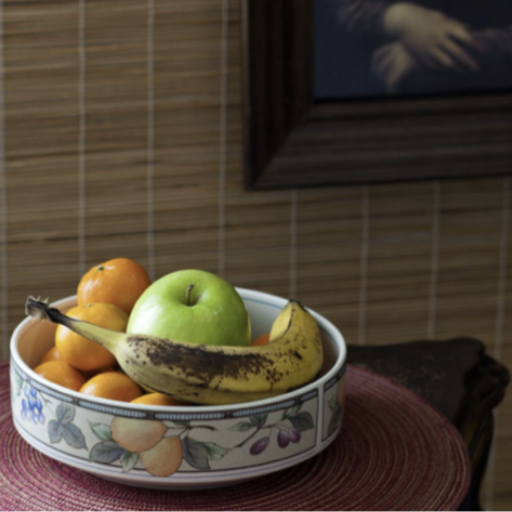

In [5]:
device = model.device
assert os.path.isfile(opt.init_img)
Image.open(opt.init_img).convert("RGB").resize((opt.W, opt.H), resample=Image.LANCZOS)


In [6]:
init_image = load_img(opt.init_img, opt).to(device)
init_image = repeat(init_image, '1 ... -> b ...', b=1)
print(opt.prompt)
print(opt.edit)

A bowl of fruits
A bowl of pears


/tmp/ipykernel_2921380/3801753494.py:40: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((opt.W, opt.H), resample=Image.LANCZOS)


## Stochastic Encoding
We can use stochastic (i.e. DDPM forward process / forward diffusion SDE) to encode the data to the noised data

Global seed set to 42


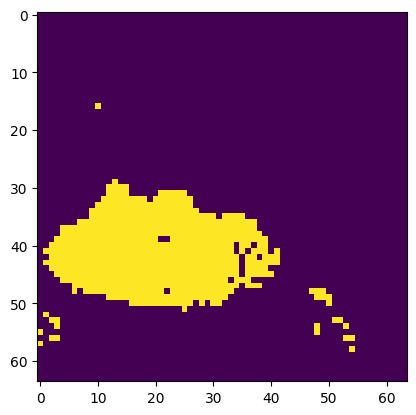

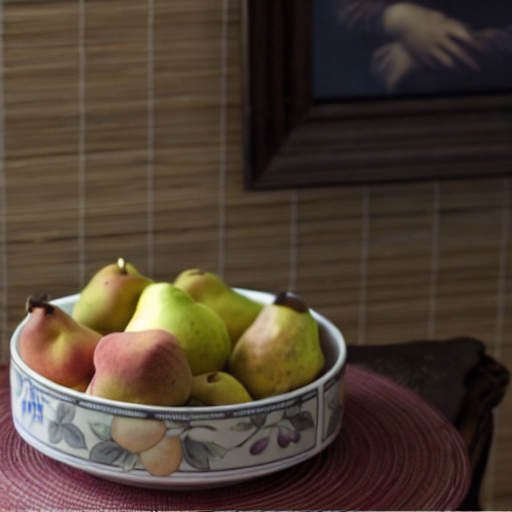

In [7]:
res = diffedit(model, init_image,
                src_prompt=opt.prompt,
                dst_prompt=opt.edit,
                encode_ratio=0.6,
                ddim_steps=15,
                encode_type="stochastic",
                method="multistep",
                order=2,
                seed=opt.seed,
                scale=opt.scale,
                precision=opt.precision
                )
Image.fromarray(res[0])

## Deterministic Encoding
We can use deterministic encoding (i.e. solving diffusion ODEs by DDIM / DPM-Solver) to encode the data to the noised data

Global seed set to 42


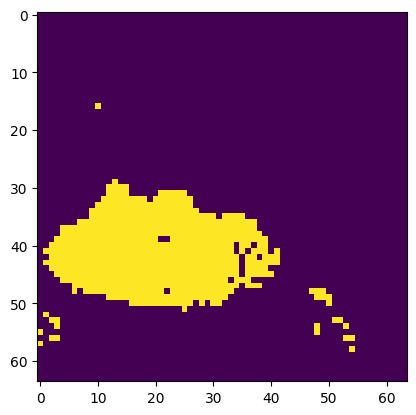

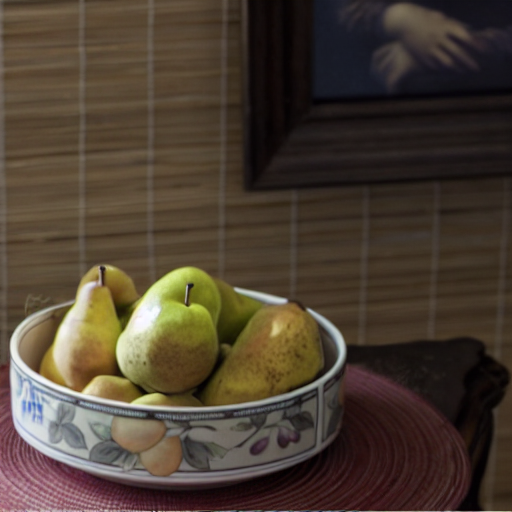

In [8]:
res = diffedit(model, init_image,
                src_prompt=opt.prompt,
                dst_prompt=opt.edit,
                encode_ratio=0.6,
                ddim_steps=20,
                encode_type="deterministic",
                method="multistep",
                order=2,
                seed=opt.seed,
                scale=opt.scale,
                precision=opt.precision
                )
Image.fromarray(res[0])